In [2]:
# load all fxns and data
from opconNosepokeFunctions import *
from supplementaryFunctions import *
from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.stats import ttest_rel
import statsmodels.api as sm
import statsmodels.formula.api as smf
def loader(name, keys='keys'):
    """Reading data from keys"""
    with open(f"/home/rishika/sim/{keys}.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for ind, key in enumerate(keys):
        dictex[key] = pd.read_csv(f"/home/rishika/sim/{ind}_{name}.csv".format(str(key)))
        dictex[key] = dictex[key].drop(['Unnamed: 0'], axis = 1)
    
    return dictex

str_sess_dict = loader('structured')
old_unstr_sess_dict = loader('old_unstructured')
new_unstr_sess_dict = loader('new_unstructured')
full_unstr_sess_dict = loader('unstructured_n_11', 'keys_full_unstructured')
# dms_unstr_sess_dict = loader('dms_unstructured', 'keys_dms')

toneStartMarker = 23
trialStartMarker = 81
trialHitMarker = 51
trialMissMarker = 86
trialUnrewMarker = 87
sessionStartMarker = 61
rewardProbMarker = 83
trialProbMarker = 88
files = {}
dms_df_dict = {}
dms_unstr_sess_dict = {}
current_animals = ['Chikorita', 'Eevee']
boxes = listdir_fullpath("/home/rishika/sim/NAS_rishika/4portProb/")
for box in boxes:
    for animal in os.listdir(box): 
        if animal in current_animals:
            try:
                print('----')
                direc = np.nonzero(np.array(os.listdir(box))==animal)[0][0]
                files[animal] = exclude_files(get_files(box+'/'+os.listdir(box)[direc]+'/'))
                
                if animal == 'Chikorita':
                    files[animal] = [file for file in files[animal] if (file >=f'{animal}-2023-09-19*.dat')]
                if animal == 'Eevee':
                    files[animal] = [file for file in files[animal] if (file >=f'{animal}-2023-09-20*.dat')]
                files[animal].sort()
                dms_df_dict[animal] = merge_files_to_df(files[animal])
                dms_unstr_sess_dict[animal] = trializer_v2(dms_df_dict[animal], [13], trialStartMarker, trialHitMarker, trialMissMarker, sessionStartMarker, trialProbMarker) 
            except pd.errors.EmptyDataError as e:
                print(animal)

----
----


In [3]:
def data_prep(dataset, hist = 20, trialsinsess=75, task = 'unstr', head = False):
    dataset = dataset.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)

    dataset['choice_t0'] = dataset.port.values
    for i in range(1,hist): 
        dataset['choice_t'+str(i)] = dataset.groupby('session#').port.shift(i)
        dataset[f'shift_t{i-1}'] = (dataset[f'choice_t{i}'] != dataset[f'choice_t{i-1}']).astype(int)
        dataset['reward_t'+str(i)] = dataset.groupby('session#').reward.shift(i)
        dataset['reward_t'+str(i)] = dataset['reward_t'+str(i)].replace({0:-1})
    dataset.dropna(inplace = True)
    
    if head == True:
        dataset = dataset.groupby('session#').head(trialsinsess)

    return dataset

In [113]:
############################################ making dfs for full datasets
# which animals can be used
animal_ref = {'Box1':'test05022023',
              'Box2':'Blissey',
              'Box3':'Chikorita',
              'Box4':'Darkrai',
              'Box5':'Eevee',
              'Box7':'Hoppip',
              'Box8':'Inkay',
              'Box9':'Jirachi',
              'Box10':'Kirlia'}

# which dictionaries of data to use
all_dicts = [str_sess_dict, new_unstr_sess_dict, old_unstr_sess_dict, dms_unstr_sess_dict]
prefixes = ['str', 'new_unstr', 'old_unstr', 'dms_unstr']
full_df = pd.DataFrame()

for k, dictionary in enumerate(all_dicts):
    prefix = prefixes[k]
    
    for key in dictionary.keys():

        sessdf = dictionary[key]
        # prep dataset with trial history 
        dataset = data_prep(sessdf, hist = 3, trialsinsess = 75, head = True)
        
        # animal name
        if dictionary==dms_unstr_sess_dict: animal = key
        else: 
            try: 
                animal = [animal_ref[s] for s in list(animal_ref.keys()) if key.split('/')[-1] in s][0]
            except IndexError:
                break
        print(key, animal, prefix)
        dataset['animal'] = animal
        dataset['task'] = prefix
        full_df = pd.concat([full_df, dataset], ignore_index = True)
dms_df = full_df[full_df.task == 'dms_unstr']
full_df = full_df[full_df.task != 'dms_unstr']

/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 str
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey str
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita str
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai str
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee str
/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee old_unstr
Eevee Eevee dms_unstr
Chikorita Chikorita dms_unstr


In [7]:
def gen_model(dataset, hist = 5, formula_type = 'c', coef = False):
    
    # check which formula type and generate formula:
    if hist>=2:
        if formula_type == 'c':
            formula = 'choice_t0 ~ C(choice_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'r':
            formula = 'choice_t0 ~ C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'int':
            formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
            for i in range(2, hist):
                formula+='+C(choice_t'+str(i)+'):C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'cr':
            formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')*C(reward_t'+str(i)+')+'
                formula = formula[:-1]            
    else:
        if formula_type == 'c': formula = 'choice_t0 ~ C(choice_t1)'
        elif formula_type == 'r': formula = 'choice_t0 ~ C(reward_t1)'
        elif formula_type == 'int': formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
        elif formula_type == 'cr': formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            
    # generate model of given hist
    model = smf.mnlogit(formula = formula, data = dataset).fit(method = 'lbfgs', maxiter = 100, disp = False)
    
    # pack scores 
    scores = (model.aic, model.bic, model.prsquared)
    if coef == True:
        coef = model.params
        coef_names = model.params.index
        return model, scores, coef, coef_names
    return model, scores

def mnlogit_runner(dataset, hist = 5, formula_type = 'c'):
    aic_hist, bic_hist, prsquared_hist = [], [], []
    
    for i in range(hist):
        model, scores, _, _ = gen_model(dataset, i, formula_type)
        aic, bic, prsquared = scores
        aic_hist.append(aic)
        bic_hist.append(bic)
        prsquared_hist.append(prsquared)
    scores_hist = (aic_hist, bic_hist, prsquared_hist)
    return scores_hist

In [8]:
##################################### model_eval with modifications for glm
arms = 4
def model_eval(model, dataset, categories = np.arange(1, 1+arms), prediction_of = 'choice_t0', return_shiftcm = False):
    
    # this takes the last model i.e. 20 trial history by default
    predictions = model.predict(dataset)
    if len(dataset[prediction_of].unique())>2:
        predicted=[np.sort(dataset[prediction_of].unique())[np.asarray(predictions).argmax(1)[i]] for i in range(len(predictions))]
        p = [predictions.loc[r,:][np.asarray(predictions).argmax(1)[ind]] for ind, r in enumerate(predictions.index)]
    else: 
        predicted = [0 if x < 0.5 else 1 for x in predictions]
        p = predictions

    dataset['predicted'] = pd.Categorical(predicted, categories = categories)
    dataset['p_predicted'] = p
    dataset['predicted_t1'] = pd.Categorical(predicted, categories = categories).shift(1)
    dataset['pred_shift_t0'] = (dataset['predicted']==dataset['predicted_t1']).replace({True: 0, False: 1})
    
    # cm, accuracy
    cm = multilabel_confusion_matrix(dataset[prediction_of], dataset.predicted)
    if len(dataset[prediction_of].unique())>2:
        accuracy = accuracy_score(dataset[prediction_of], dataset.predicted)
    else:
        accuracy = accuracy_score(dataset[dataset.shift_t0==1][prediction_of], dataset[dataset.shift_t0==1].predicted)
    full_cm = pd.crosstab(dataset[prediction_of], dataset.predicted, normalize = 'index', dropna = False)
    if return_shiftcm == True:
        shift_cm = pd.crosstab(dataset.shift_t0,
                              dataset.pred_shift_t0,
                              normalize = 'index',
                              dropna = False)
        return cm, accuracy, full_cm, shift_cm
    # generate a plot of predictions
    #################################
    return cm, accuracy, full_cm

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin
 
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.formula,data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

In [10]:
# k-fold cross validation
def gen_mnlogit_formula(dataset, hist, formula_type = 'c'):
    # check which formula type and generate formula:
    if hist>=2:
        if formula_type == 'c':
            formula = 'choice_t0 ~ C(choice_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'r':
            formula = 'choice_t0 ~ C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'int':
            formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
            for i in range(2, hist):
                formula+='+C(choice_t'+str(i)+'):C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'cr':
            formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')*C(reward_t'+str(i)+')+'
                formula = formula[:-1]            
    else:
        if formula_type == 'c': formula = 'choice_t0 ~ C(choice_t1)'
        elif formula_type == 'r': formula = 'choice_t0 ~ C(reward_t1)'
        elif formula_type == 'int': formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
        elif formula_type == 'cr': formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
    return formula

def get_regressors(ln, formula_type = 'c'):
    if ln>=2:
        if formula_type == 'c':regressors = ['choice_t'+str(i) for i in range(1,ln)]
        elif formula_type == 'r':regressors = ['reward_t'+str(i) for i in range(1,ln)]
        elif formula_type == 'int':regressors = ['choice_t'+str(i) for i in range(1,ln)] + ['reward_t'+str(i) for i in range(1,ln)]
        elif formula_type == 'cr':regressors = ['choice_t'+str(i) for i in range(1,ln)] + ['reward_t'+str(i) for i in range(1,ln)]
    else:
        if formula_type == 'c':regressors = 'choice_t1'
        elif formula_type == 'r':regressors = 'reward_t1'
        elif formula_type == 'int':regressors = ['choice_t1', 'reward_t1']
        elif formula_type == 'cr':regressors = ['choice_t1', 'reward_t1']
    return regressors

In [121]:
arms = 4
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
hist = 3
kfolddf = pd.DataFrame()
kf = []
model_name = ['Choice', 'Reward', 'Interactions', 'Full']
shorts = ['c', 'r', 'int', 'cr']
prediction_of = 'choice_t0'

for animal, dataset in full_df.groupby('animal'):
    
    switchonly = dataset[dataset.shift_t0==1]
    
    # generate train-test split using grouped session data - for different session histories
    dataset_type = 'full'
    y = dataset.choice_t0
    groups = np.array(dataset['session#'].to_list())
    kfolder = GroupKFold(n_splits = 10)
    
    for n, abbrev in enumerate(shorts):
        for ln in range(1,hist):
            X = dataset[get_regressors(ln, abbrev)]

            for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):
                
                # separate regressors into train and test
                train_data = dataset.iloc[train_ind]
                test_data = X.iloc[test_ind]
                
                # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                model, scores = gen_model(train_data, ln, abbrev)
                model.set_null_options(attach_results = True)
                llnull = model.llnull
                nullmodel = model.res_null
                
                # generate predictions
                predictions = model.predict(test_data)
                prediction = np.array(predictions)
                # Calculate predicted action and probability for each test sample
                predicted = np.sort(dataset[prediction_of].unique())[prediction.argmax(axis=1)]
                p = prediction[np.arange(len(prediction)), prediction.argmax(axis=1)]
                
                # calc llfit
                llfit = np.nansum(np.log(p))
                
                # calc accuracy
                accuracy = accuracy_score(y.iloc[test_ind], predicted)
                b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)
                
                # calc llnull on test data
                # Calculate null predictions for test data
                nullpredictions = np.tile(np.unique(nullmodel.predict()), (len(test_data), 1))

                # Calculate predicted action and probability for each test sample
                nullpredicted = np.sort(dataset[prediction_of].unique())[nullpredictions.argmax(axis=1)]
                nullp = nullpredictions[np.arange(len(nullpredictions)), nullpredictions.argmax(axis=1)]
                
                # Calculate log-likelihood of null model on test data
                testllnull = np.nansum(np.log(nullp))

                # Calculate test prsq
                testprsq = 1 - (llfit / testllnull)
                
                # store scores, model details
                kf.append([animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                           llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])
               
    # generate train-test split using grouped session data - for different session histories
    dataset_type = 'switchonly'
    y = switchonly.choice_t0
    groups = np.array(switchonly['session#'].to_list())
    kfolder = GroupKFold(n_splits = 10)
    
    for n, abbrev in enumerate(shorts):
        for ln in range(1,hist):
            X = switchonly[get_regressors(ln, abbrev)]

            for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):
                
                # separate regressors into train and test
                train_data = switchonly.iloc[train_ind]
                test_data = X.iloc[test_ind]
                
                # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                model, scores = gen_model(train_data, ln, abbrev)
                model.set_null_options(attach_results = True)
                llnull = model.llnull
                nullmodel = model.res_null
                
                # generate predictions
                predictions = model.predict(test_data)
                prediction = np.array(predictions)
                # Calculate predicted action and probability for each test sample
                predicted = np.sort(dataset[prediction_of].unique())[prediction.argmax(axis=1)]
                p = prediction[np.arange(len(prediction)), prediction.argmax(axis=1)]
                
                # calc prsq
                llfit = np.nansum(np.log(p))
                
                # calc accuracy
                accuracy = accuracy_score(y.iloc[test_ind], predicted)
                b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)
                
                # calc llnull on test data
                # Calculate null predictions for test data
                nullpredictions = np.tile(np.unique(nullmodel.predict()), (len(test_data), 1))

                # Calculate predicted action and probability for each test sample
                nullpredicted = np.sort(dataset[prediction_of].unique())[nullpredictions.argmax(axis=1)]
                nullp = nullpredictions[np.arange(len(nullpredictions)), nullpredictions.argmax(axis=1)]
                
                # Calculate log-likelihood of null model on test data
                testllnull = np.nansum(np.log(nullp))

                # Calculate test prsq
                testprsq = 1 - (llfit / testllnull)

                # store scores, model details
                kf.append([animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                           llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])
    print(animal, abbrev, nfold)
kfolddf = pd.DataFrame(kf,
                       columns=['animal', 'dataset', 'model', 'len', 'nfold', 'aic', 'bic', 'train_prsq',
                                'llnull', 'llfit', 'test_llnull','test_prsq', 'accuracy', 'b_accuracy'])

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

Blissey cr 9


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Chikorita cr 9


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Darkrai cr 9


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Eevee cr 9


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

test05022023 cr 9


In [122]:
kfolddf.to_csv('/home/rishika/sim/kfolddf.csv')

In [123]:
sim_qldf = pd.read_csv('/home/rishika/sim/sim_qldf.csv')
sim_qldf = sim_qldf.drop(columns = 'Unnamed: 0')

arms = 4
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
hist = 3
sim_kfolddf = pd.DataFrame()
kf = []
model_name = ['Choice', 'Reward', 'Interactions', 'Full']
shorts = ['c', 'r', 'int', 'cr']
prediction_of = 'choice_t0'
partial_qldf = sim_qldf[(sim_qldf['alpha']==0.1) & (sim_qldf['tau']==0.1) & (sim_qldf['animal']=='Blissey')]

for (animal, alpha, tau), dataset in partial_qldf.groupby(['animal', 'alpha', 'tau']):
    
    dataset = data_prep(dataset, hist = hist, trialsinsess = 75, head = True)
    
    switchonly = dataset[dataset.shift_t0==1]
    
    # generate train-test split using grouped session data - for different session histories
    dataset_type = 'full'
    y = dataset.choice_t0
    groups = np.array(dataset['session#'].to_list())
    kfolder = GroupKFold(n_splits = 10)
    
    for n, abbrev in enumerate(shorts):
        for ln in range(1,hist):
            X = dataset[get_regressors(ln, abbrev)]
        
            for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):
                
                # separate regressors into train and test
                train_data = dataset.iloc[train_ind]
                test_data = X.iloc[test_ind]
                
                # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                model, scores = gen_model(train_data, ln, abbrev)
                model.set_null_options(attach_results = True)
                llnull = model.llnull
                nullmodel = model.res_null
                
                # generate predictions
                predictions = model.predict(test_data)
                prediction = np.array(predictions)
                # Calculate predicted action and probability for each test sample
                predicted = np.sort(dataset[prediction_of].unique())[prediction.argmax(axis=1)]
                p = prediction[np.arange(len(prediction)), prediction.argmax(axis=1)]
                
                # calc prsq
                llfit = np.nansum(np.log(p))
                
                # calc accuracy
                accuracy = accuracy_score(y.iloc[test_ind], predicted)
                b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)
                
                # calc llnull on test data
                # Calculate null predictions for test data
                nullpredictions = np.tile(np.unique(nullmodel.predict()), (len(test_data), 1))

                # Calculate predicted action and probability for each test sample
                nullpredicted = np.sort(dataset[prediction_of].unique())[nullpredictions.argmax(axis=1)]
                nullp = nullpredictions[np.arange(len(nullpredictions)), nullpredictions.argmax(axis=1)]

                # Calculate log-likelihood of null model on test data
                testllnull = np.nansum(np.log(nullp))

                # Calculate test prsq
                testprsq = 1 - (llfit / testllnull) 
                
                # store scores, model details
                kf.append([alpha, tau, animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                           llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])
               
    # generate train-test split using grouped session data - for different session histories
    dataset_type = 'switchonly'
    y = switchonly.choice_t0
    groups = np.array(switchonly['session#'].to_list())
    kfolder = GroupKFold(n_splits = 10)
    
    for n, abbrev in enumerate(shorts):
        for ln in range(1,hist):
            X = switchonly[get_regressors(ln, abbrev)]

            for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):
                
                # separate regressors into train and test
                train_data = switchonly.iloc[train_ind]
                test_data = X.iloc[test_ind]
                
                # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                model, scores = gen_model(train_data, ln, abbrev)
                model.set_null_options(attach_results = True)
                llnull = model.llnull
                nullmodel = model.res_null
                
                # generate predictions
                predictions = model.predict(test_data)
                prediction = np.array(predictions)
                # Calculate predicted action and probability for each test sample
                predicted = np.sort(dataset[prediction_of].unique())[prediction.argmax(axis=1)]
                p = prediction[np.arange(len(prediction)), prediction.argmax(axis=1)]
                
                # calc prsq
                llfit = np.nansum(np.log(p))
                
                # calc accuracy
                accuracy = accuracy_score(y.iloc[test_ind], predicted)
                b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)
                
                # calc llnull on test data
                # Calculate null predictions for test data
                nullpredictions = np.tile(np.unique(nullmodel.predict()), (len(test_data), 1))

                # Calculate predicted action and probability for each test sample
                nullpredicted = np.sort(dataset[prediction_of].unique())[nullpredictions.argmax(axis=1)]
                nullp = nullpredictions[np.arange(len(nullpredictions)), nullpredictions.argmax(axis=1)]

                # Calculate log-likelihood of null model on test data
                testllnull = np.nansum(np.log(nullp))

                # Calculate test prsq
                testprsq = 1 - (llfit / testllnull) 
                
                # store scores, model details
                kf.append([alpha, tau, animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                           llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])
        print(animal, alpha, tau, abbrev)
sim_kfolddf = pd.DataFrame(kf,
                       columns=['alpha', 'tau', 'animal', 'dataset', 'model', 'len', 'nfold', 'aic',
                                'bic', 'train_prsq',
                                'llnull', 'llfit', 'test_llnull', 'test_prsq', 'accuracy', 'b_accuracy'])

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Blissey 0.1 0.1 c
Blissey 0.1 0.1 r


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Blissey 0.1 0.1 int


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Blissey 0.1 0.1 cr


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 1.0)

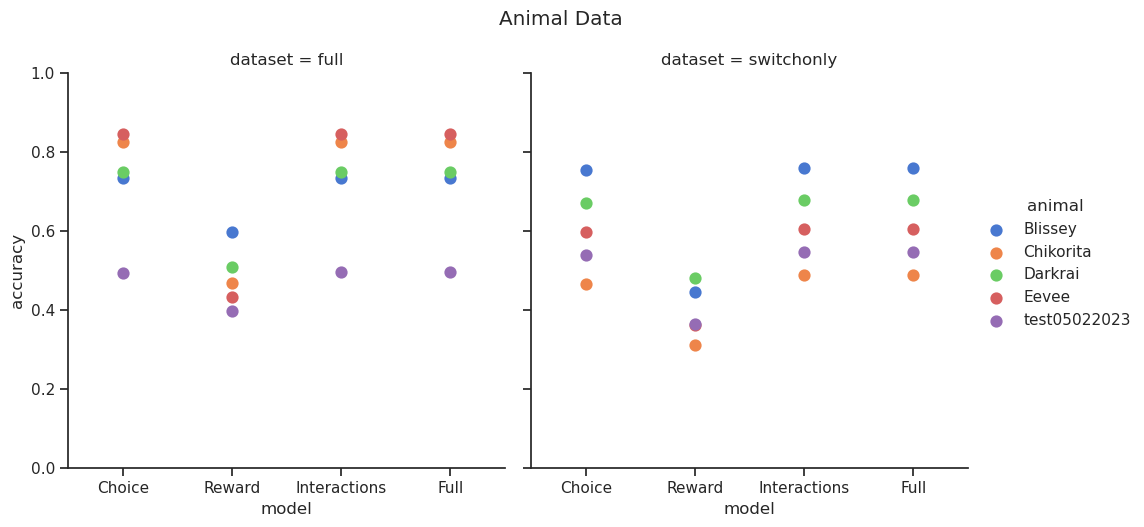

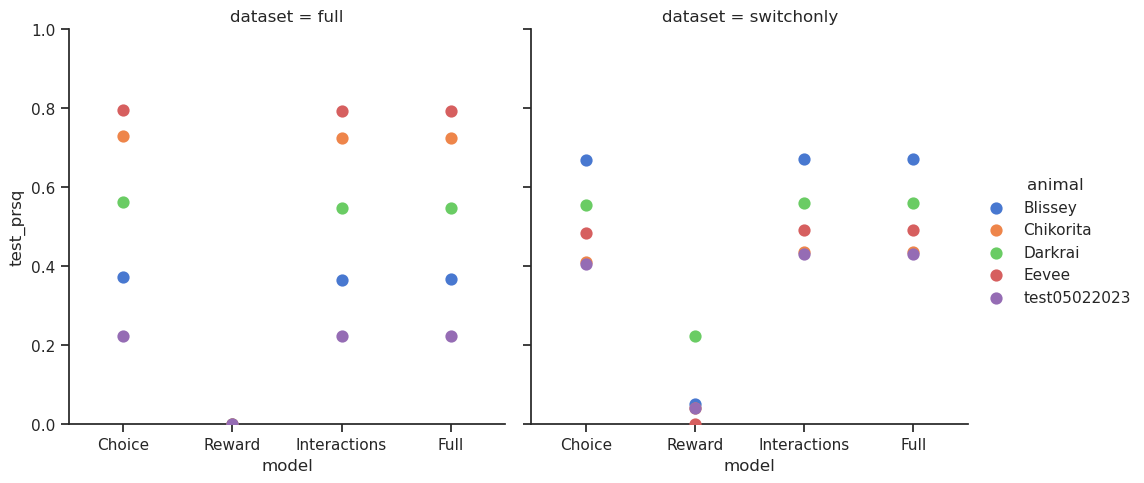

In [124]:
calc = kfolddf.groupby(['animal', 'dataset', 'model', 'len']).accuracy.mean().reset_index()
plotthis = calc.groupby(['animal', 'dataset', 'model']).accuracy.max().reset_index()
calc = kfolddf.groupby(['animal', 'dataset', 'model', 'len']).test_prsq.mean().reset_index()
plotthis2 = calc.groupby(['animal', 'dataset', 'model']).test_prsq.max().reset_index()

kfolddf = pd.read_csv('/home/rishika/sim/kfolddf.csv')
kfolddf = kfolddf.drop(columns = 'Unnamed: 0')

sns.catplot(data = plotthis, x = 'model', y = 'accuracy', hue = 'animal', kind = 'point',
            col = 'dataset', palette= 'muted', join = False, 
            order = ['Choice', 'Reward', 'Interactions', 'Full'])
plt.ylim(0,1)

plt.suptitle('Animal Data', y=1.05)
sns.catplot(data = plotthis2, x = 'model', y = 'test_prsq', hue = 'animal', kind = 'point',
            col = 'dataset', palette= 'muted', join = False, 
            order = ['Choice', 'Reward', 'Interactions', 'Full'])
plt.ylim(0,1)

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 1.0)

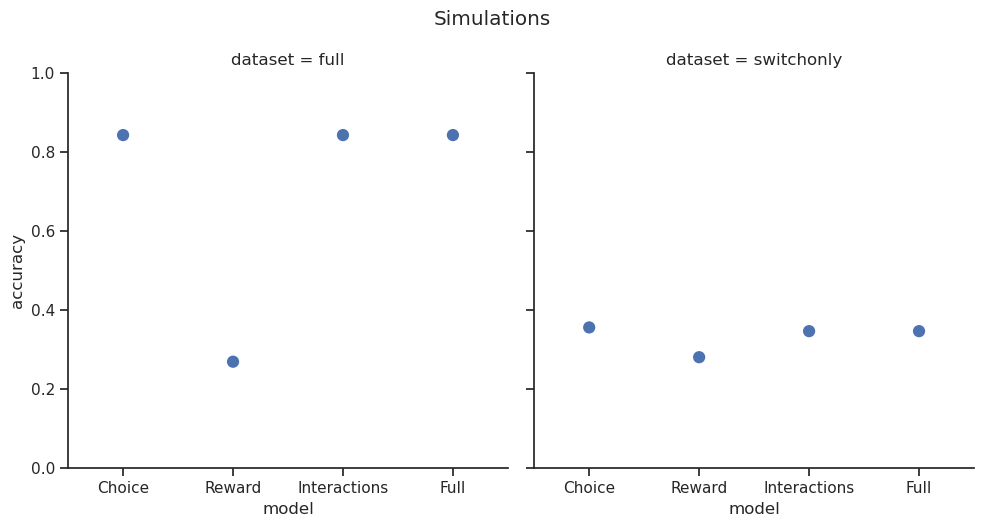

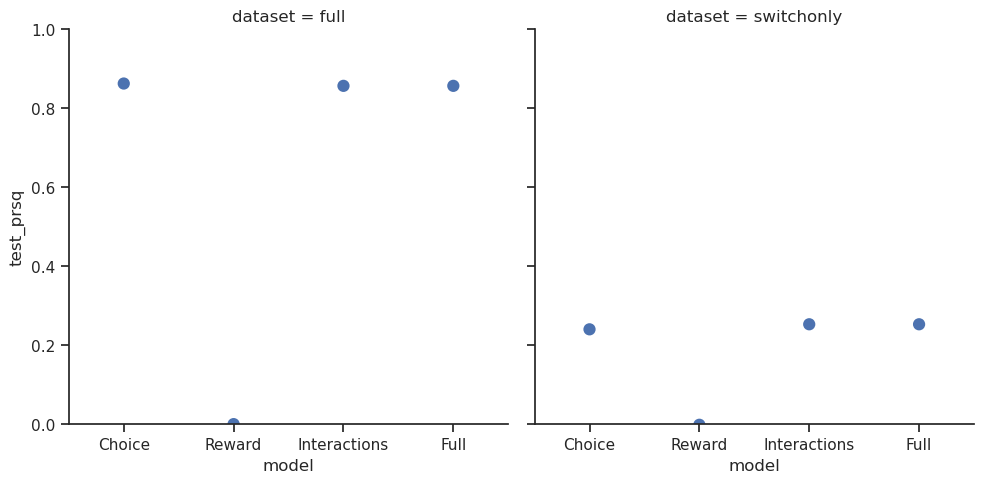

In [125]:
calc = sim_kfolddf.groupby(['animal', 'dataset', 'model', 'len']).accuracy.mean().reset_index()
plotthis = calc.groupby(['animal', 'dataset', 'model']).accuracy.max().reset_index()
calc = sim_kfolddf.groupby(['animal', 'dataset', 'model', 'len']).test_prsq.mean().reset_index()
plotthis2 = calc.groupby(['animal', 'dataset', 'model']).test_prsq.max().reset_index()

sns.catplot(data = plotthis, x = 'model', y = 'accuracy',  kind = 'point',
            col = 'dataset', join = False, 
            order = ['Choice', 'Reward', 'Interactions', 'Full'])
plt.ylim(0,1)
plt.suptitle('Simulations', y=1.05)
sns.catplot(data = plotthis2, x = 'model', y = 'test_prsq',  kind = 'point',
            col = 'dataset',  join = False, 
            order = ['Choice', 'Reward', 'Interactions', 'Full'])
plt.ylim(0,1)

In [5]:
############################################ making dfs for full datasets
# which animals can be used
animal_ref = {'Box1':'test05022023',
              'Box2':'Blissey',
              'Box3':'Chikorita',
              'Box4':'Darkrai',
              'Box5':'Eevee',
              'Box7':'Hoppip',
              'Box8':'Inkay',
              'Box9':'Jirachi',
              'Box10':'Kirlia'}

# which dictionaries of data to use
all_dicts = [str_sess_dict, new_unstr_sess_dict, old_unstr_sess_dict, dms_unstr_sess_dict]
prefixes = ['str', 'new_unstr', 'old_unstr', 'dms_unstr']
full_df = pd.DataFrame()

for k, dictionary in enumerate(all_dicts):
    prefix = prefixes[k]
    
    for key in dictionary.keys():

        sessdf = dictionary[key]
        # prep dataset with trial history 
        dataset = data_prep(sessdf, hist = 3, trialsinsess = 0, head = False)
        
        # animal name
        if dictionary==dms_unstr_sess_dict: animal = key
        else: 
            try: 
                animal = [animal_ref[s] for s in list(animal_ref.keys()) if key.split('/')[-1] in s][0]
            except IndexError:
                break
        print(key, animal, prefix)
        dataset['animal'] = animal
        dataset['task'] = prefix
        full_df = pd.concat([full_df, dataset], ignore_index = True)
dms_df = full_df[full_df.task == 'dms_unstr']
full_df = full_df[full_df.task != 'dms_unstr']

/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 str
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey str
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita str
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai str
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee str
/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee old_unstr
Eevee Eevee dms_unstr
Chikorita Chikorita dms_unstr


In [11]:
arms = 4
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
hist = 3
kfolddf = pd.DataFrame()
kf = []
model_name = ['Choice', 'Reward', 'Interactions', 'Full']
shorts = ['c', 'r', 'int', 'cr']
prediction_of = 'choice_t0'

for animal, dataset in dms_df.groupby('animal'):
    
    switchonly = dataset[dataset.shift_t0==1]
    
    # generate train-test split using grouped session data - for different session histories
    dataset_type = 'full'
    y = dataset.choice_t0
    groups = np.array(dataset['session#'].to_list())
    kfolder = GroupKFold(n_splits = 10)
    
    for n, abbrev in enumerate(shorts):
        for ln in range(1,hist):
            X = dataset[get_regressors(ln, abbrev)]

            for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):
                
                # separate regressors into train and test
                train_data = dataset.iloc[train_ind]
                test_data = X.iloc[test_ind]
                
                # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                model, scores = gen_model(train_data, ln, abbrev)
                model.set_null_options(attach_results = True)
                llnull = model.llnull
                nullmodel = model.res_null
                
                # generate predictions
                predictions = model.predict(test_data)
                prediction = np.array(predictions)
                # Calculate predicted action and probability for each test sample
                predicted = np.sort(dataset[prediction_of].unique())[prediction.argmax(axis=1)]
                p = prediction[np.arange(len(prediction)), prediction.argmax(axis=1)]
                
                # calc llfit
                llfit = np.nansum(np.log(p))
                
                # calc accuracy
                accuracy = accuracy_score(y.iloc[test_ind], predicted)
                b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)
                
                # calc llnull on test data
                # Calculate null predictions for test data
                nullpredictions = np.tile(np.unique(nullmodel.predict()), (len(test_data), 1))

                # Calculate predicted action and probability for each test sample
                nullpredicted = np.sort(dataset[prediction_of].unique())[nullpredictions.argmax(axis=1)]
                nullp = nullpredictions[np.arange(len(nullpredictions)), nullpredictions.argmax(axis=1)]
                
                # Calculate log-likelihood of null model on test data
                testllnull = np.nansum(np.log(nullp))

                # Calculate test prsq
                testprsq = 1 - (llfit / testllnull)
                
                # store scores, model details
                kf.append([animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                           llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])
               
    # generate train-test split using grouped session data - for different session histories
    dataset_type = 'switchonly'
    y = switchonly.choice_t0
    groups = np.array(switchonly['session#'].to_list())
    kfolder = GroupKFold(n_splits = 10)
    
    for n, abbrev in enumerate(shorts):
        for ln in range(1,hist):
            X = switchonly[get_regressors(ln, abbrev)]

            for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):
                
                # separate regressors into train and test
                train_data = switchonly.iloc[train_ind]
                test_data = X.iloc[test_ind]
                
                # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                model, scores = gen_model(train_data, ln, abbrev)
                model.set_null_options(attach_results = True)
                llnull = model.llnull
                nullmodel = model.res_null
                
                # generate predictions
                predictions = model.predict(test_data)
                prediction = np.array(predictions)
                # Calculate predicted action and probability for each test sample
                predicted = np.sort(dataset[prediction_of].unique())[prediction.argmax(axis=1)]
                p = prediction[np.arange(len(prediction)), prediction.argmax(axis=1)]
                
                # calc prsq
                llfit = np.nansum(np.log(p))
                
                # calc accuracy
                accuracy = accuracy_score(y.iloc[test_ind], predicted)
                b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)
                
                # calc llnull on test data
                # Calculate null predictions for test data
                nullpredictions = np.tile(np.unique(nullmodel.predict()), (len(test_data), 1))

                # Calculate predicted action and probability for each test sample
                nullpredicted = np.sort(dataset[prediction_of].unique())[nullpredictions.argmax(axis=1)]
                nullp = nullpredictions[np.arange(len(nullpredictions)), nullpredictions.argmax(axis=1)]
                
                # Calculate log-likelihood of null model on test data
                testllnull = np.nansum(np.log(nullp))

                # Calculate test prsq
                testprsq = 1 - (llfit / testllnull)

                # store scores, model details
                kf.append([animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                           llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])
    print(animal, abbrev, nfold)
kfolddf = pd.DataFrame(kf,
                       columns=['animal', 'dataset', 'model', 'len', 'nfold', 'aic', 'bic', 'train_prsq',
                                'llnull', 'llfit', 'test_llnull','test_prsq', 'accuracy', 'b_accuracy'])

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Chikorita cr 9


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/mini

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/mini

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/mini

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3

Eevee cr 9


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 1.0)

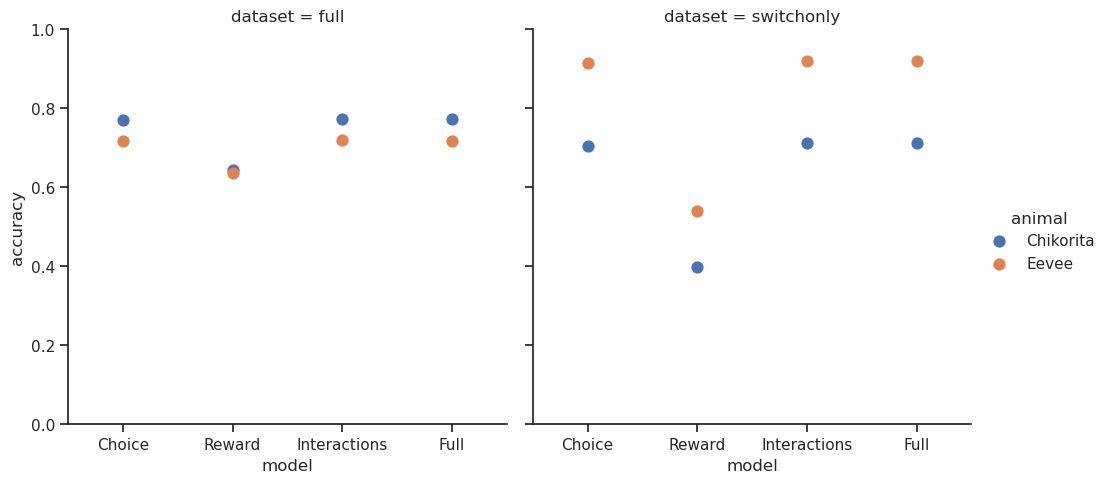

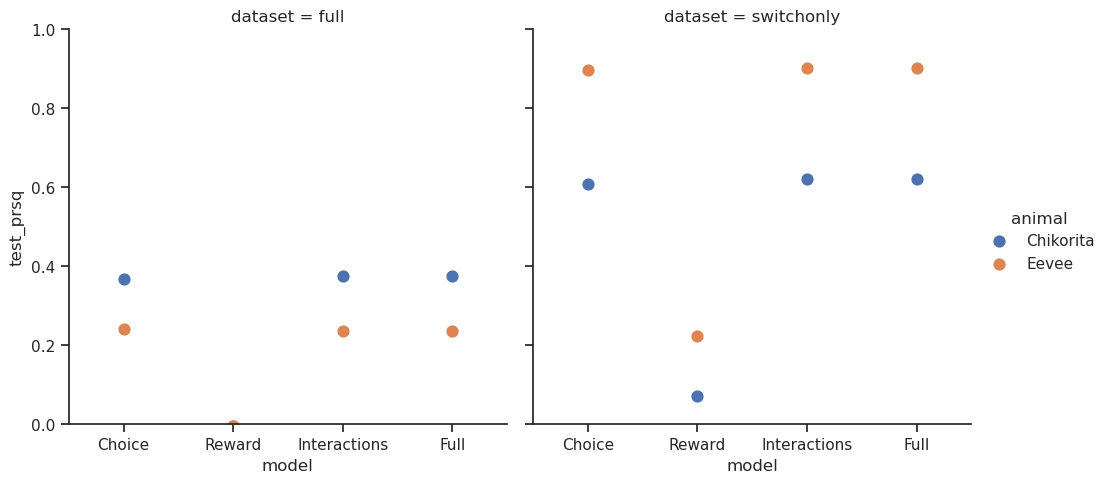

In [15]:
calc = kfolddf.groupby(['animal', 'dataset', 'model', 'len']).accuracy.mean().reset_index()
plotthis = calc.groupby(['animal', 'dataset', 'model']).accuracy.max().reset_index()
calc = kfolddf.groupby(['animal', 'dataset', 'model', 'len']).test_prsq.mean().reset_index()
plotthis2 = calc.groupby(['animal', 'dataset', 'model']).test_prsq.max().reset_index()

sns.catplot(data = plotthis, x = 'model', y = 'accuracy',  kind = 'point', hue= 'animal',
            col = 'dataset', join = False, 
            order = ['Choice', 'Reward', 'Interactions', 'Full'])
plt.ylim(0,1)
# plt.suptitle('Simulations', y=1.05)
sns.catplot(data = plotthis2, x = 'model', y = 'test_prsq',  kind = 'point', hue = 'animal',
            col = 'dataset',  join = False, 
            order = ['Choice', 'Reward', 'Interactions', 'Full'])
plt.ylim(0,1)